# Filled Julia sets: Comparing methods

MCS 275 Spring 2022 - Emily Dumas

## Convention

We'll compute the filled Julia set of $f(z) = z^2 + c$.  Previously, we only discussed $c=0$ and $c=-1$ in class, and other values of $c$ were added to the example notebook between lectures.

This notebook shows three ways to do the same thing, and all are set to make a 800x800 image with 500 iterations.  The first method (using Python for loops) is very slow!

## Setup

In [1]:
import numpy as np
from PIL import Image
import time

In [2]:
# Some values of c to try

c_circle = 0
c_basilica = -1
c_rabbit = -0.123 + 0.745j
c_curly_snowflake = -0.4-0.582j  # my name for this!
c_airplane = -1.75487766624669276

## Using Python for loops

In [3]:
def escapes(c,a,n):
    """Determines if orbit of a under z->z^2+c escapes |z|<2 within
    n iterations.
    """
    for _ in range(n):
        if abs(a) >= 2:
            return True
        a = a*a+c
    return False

def filled_julia_set_for(c,xmin=-1.8,xmax=1.8,ymin=-1.8,ymax=1.8,xres=500,yres=500,maxiter=100):
    """Create PIL image of the filled Julia set of z^2+c"""
    x = np.linspace(xmin,xmax,xres)
    y = np.linspace(ymin,ymax,yres)

    xx, yy = np.meshgrid(x,y)
    zz = xx + 1j*yy
    
    f = lambda z: escapes(c,z,maxiter)
    
    res = np.zeros_like(zz,dtype="bool")
    for i in range(len(x)):
        for j in range(len(y)):
            res[j,i] = f(zz[j,i])  # j is the row, and indexing is row,column
    
    return Image.fromarray( 255*res.astype("uint8"), mode="L" ).transpose(method=Image.FLIP_TOP_BOTTOM)

12.515106916427612 seconds


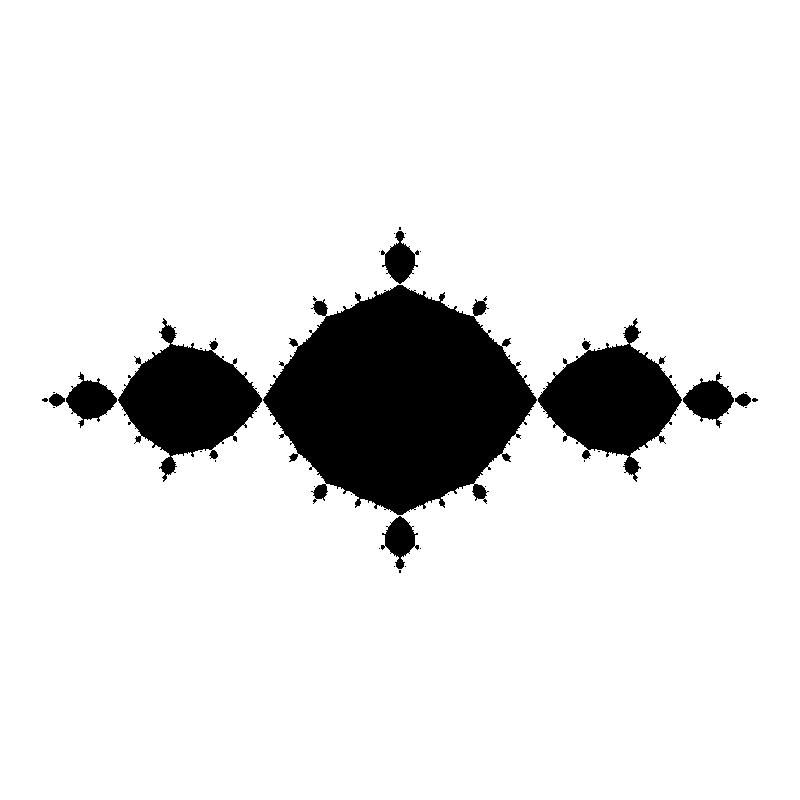

In [5]:
t_start = time.time()
img = filled_julia_set_for(c_basilica,maxiter=500,xres=800,yres=800)
t_end = time.time()

print(t_end-t_start,"seconds")
img

## Using numpy.vectorize

This is the method we discussed in Lecture 27, but the code has been cleaned up a bit.

In [12]:
def escapes(c,a,n):
    """Determines if orbit of a under z->z^2+c escapes |z|<2 within
    n iterations.
    """
    for _ in range(n):
        if abs(a) >= 2:
            return True
        a = a*a+c
    return False

def filled_julia_set_vectorize(c,xmin=-1.8,xmax=1.8,ymin=-1.8,ymax=1.8,xres=500,yres=500,maxiter=100):
    """Create PIL image of the filled Julia set of z^2+c"""
    x = np.linspace(xmin,xmax,xres)
    y = np.linspace(ymin,ymax,yres)

    xx, yy = np.meshgrid(x,y)
    zz = xx + 1j*yy
    
    f = lambda z: escapes(c,z,maxiter)
    
    return Image.fromarray( 255*np.vectorize(f)(zz).astype("uint8"), mode="L" ).transpose(method=Image.FLIP_TOP_BOTTOM)

3.8326313495635986 seconds


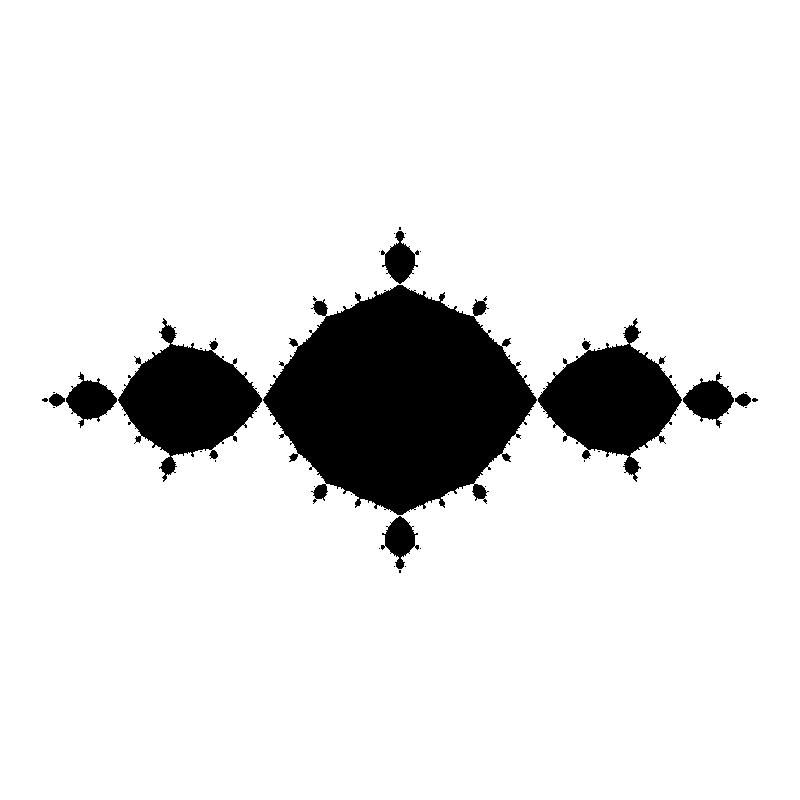

In [14]:
t_start = time.time()
img = filled_julia_set_vectorize(c_basilica,maxiter=500,xres=800,yres=800)
t_end = time.time()

print(t_end-t_start,"seconds")
img

## Using numpy ufuncs

An even faster approach is to use numpy's overloading of the arithmetic operations to apply $z^2+c$ to each element of the grid simultaneously.

If we do this naively, applying the function `maxiter` times to every point, many of the calculations will overflow.  To prevent this, we can use a mask (boolean array) to stop applying the function as soon as a point leaves $|z|<2$.

In [15]:
def filled_julia_set_ufunc(c,xmin=-1.8,xmax=1.8,ymin=-1.8,ymax=1.8,xres=500,yres=500,maxiter=100):
        """Create PIL image of the filled Julia set of z^2+c"""
        x = np.linspace(xmin,xmax,xres)
        y = np.linspace(ymin,ymax,yres)

        xx, yy = np.meshgrid(x,y)
        zz = xx + 1j*yy
    
        m = np.ones_like(zz,dtype="bool") # Mask: True means we are
                                          # still applying f to that
                                          # point in the grid.
    
        for _ in range(maxiter):
            zz[m] = zz[m]**2 + c # apply z^2+c to each point where m is True
            m[m] &= np.abs(zz[m])<2 # Set mask to False for any point
                                    # that now has abs(z)>=2
        
        return Image.fromarray( 255*((np.abs(zz)>=2).astype("uint8")), mode="L" ).transpose(method=Image.FLIP_TOP_BOTTOM)

0.6942436695098877 seconds


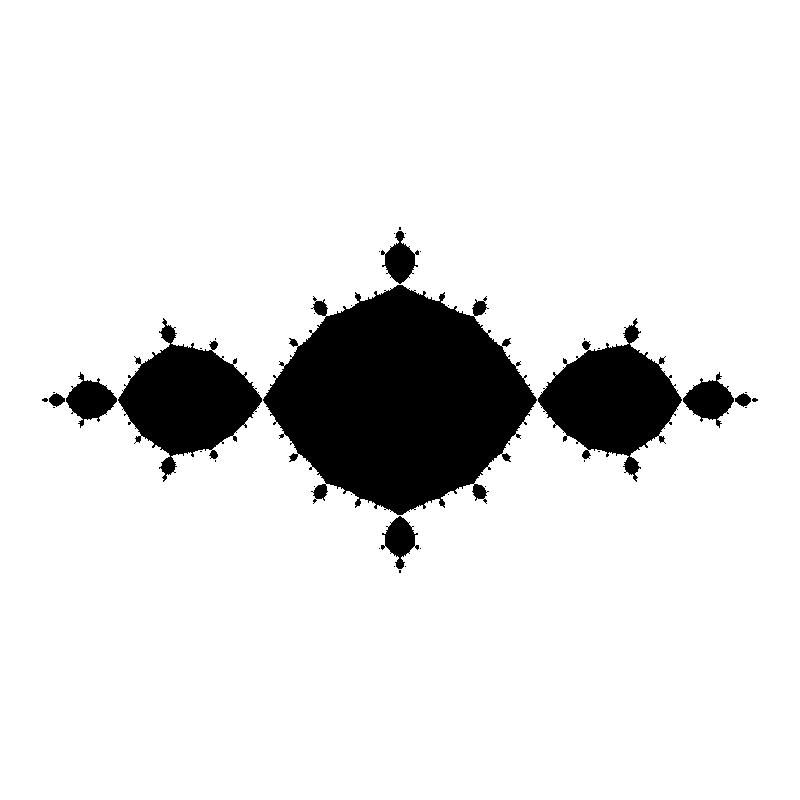

In [16]:
t_start = time.time()
img = filled_julia_set_ufunc(c_basilica,maxiter=500,xres=800,yres=800)
t_end = time.time()

print(t_end-t_start,"seconds")
img